In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import numpy as np
import gpflow
gpflow.config.set_default_float(np.float32)

from sgptools.utils.tsp import run_tsp # TSP/VRP solver for initial path planning
from sgptools.kernels import get_kernel
from sgptools.kernels.attentive import *
from sgptools.utils.gpflow import get_model_params
from sgptools.utils.data import Dataset

np.random.seed(1234)
tf.random.set_seed(1234)

/home/itskalvik/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
2025-11-24 09:52:18.553278: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-24 09:52:18.554664: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-24 09:52:18.560261: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-24 09:52:18.574932: E ex

In [2]:
# Method to extract lengthscales map from attentive non stationary kernel
def predict_lengthscales(X, lengthscales, kernel):
        preds = np.zeros(len(X))
        repre1 = kernel.get_representations(X)
        for i in range(len(lengthscales)):
                attention = tf.tensordot(repre1[:, i],
                                         tf.transpose(repre1[:, i]),
                                         axes=0)
                preds += np.diag(attention) * lengthscales[i]
        return preds

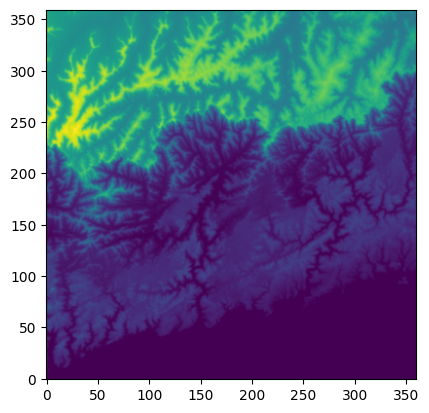

Original dataset shape: (360, 360)
Training data shapes (X, y): (5000, 2), (5000, 1)
Testing data shapes (X, y): (20000, 2), (20000, 1)
Candidate data shape (X): (150, 2)
Dataset loaded and preprocessed successfully.


2025-11-24 09:52:30.407696: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [3]:
# Load data
data = np.load("N17E073.npy")
plt.imshow(data.T, origin="lower")
plt.show()

dataset = Dataset(data=data, dtype=np.float32,
                  num_train=5000, num_test=20000)
X_train, y_train = dataset.get_train()

# Train GP/Kernel 
lengthscales = np.linspace(1, 10, 10)
_, noise_variance, kernel, model = get_model_params(
    X_train=X_train, y_train=y_train, 
    kernel=get_kernel('Attentive')(lengthscales=lengthscales),
    optimizer='tf.Nadam',
    learning_rate=1e-2,
    max_steps=1000,
    return_model=True,
    verbose=False)

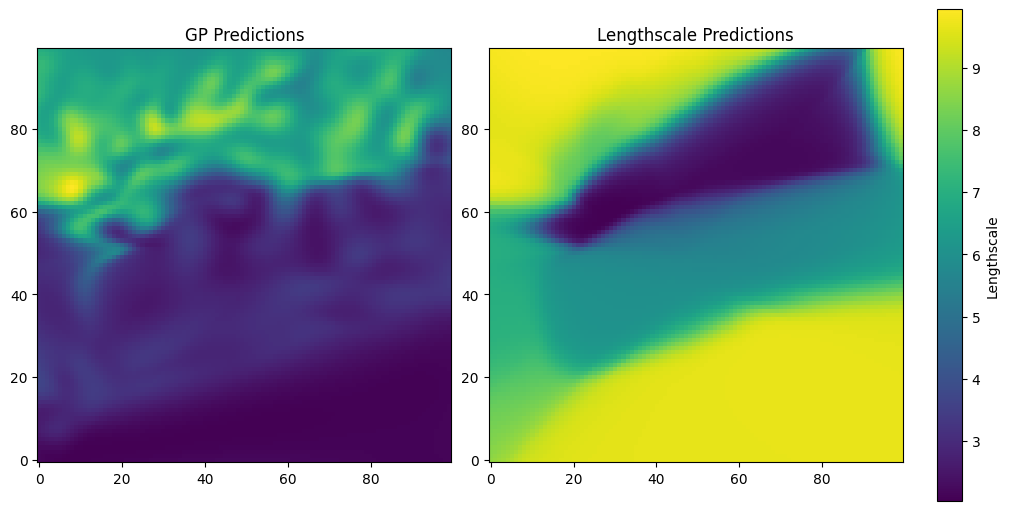

In [4]:
# Plot GP prediction and lengthscale map
X_test, _ = dataset.get_test()
grid_x, grid_y = np.mgrid[min(X_test[:, 0]):max(X_test[:, 0]):100j, 
                          min(X_test[:, 1]):max(X_test[:, 1]):100j]
X_test = np.stack([grid_x, grid_y], axis=-1)
x_dim, y_dim = X_test.shape[:2]
X_test = X_test.reshape(-1, 2).astype(X_train.dtype)

mean, std = model.predict_f(X_test)
lengthscale_preds = predict_lengthscales(X_test, lengthscales, kernel)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)

# First subplot — training data
sc1 = axes[0].imshow(mean.numpy().reshape(x_dim, y_dim).T, origin="lower")
axes[0].set_title("GP Predictions")
axes[0].set_aspect('equal')

# Second subplot — test data
sc2 = axes[1].imshow(lengthscale_preds.reshape(x_dim, y_dim).T, origin="lower")
axes[1].set_title("Lengthscale Predictions")
axes[1].set_aspect('equal')

# Shared colorbar
fig.colorbar(sc2, ax=axes, orientation='vertical', 
             fraction=0.05, pad=0.04, label='Lengthscale')

plt.show()

In [ ]:
import numpy as np
from scipy.spatial.distance import cdist
from numba import njit


@njit
def _compute_gains_numba(remaining_idxs, coverages, current_coverage):
    """
    Numba-accelerated computation of marginal gains for all remaining candidates.

    Parameters
    ----------
    remaining_idxs : 1D ndarray[int]
        Indices of candidates still available for selection.
    coverages : 2D ndarray[bool], shape (n_candidates, v)
        Binary coverage maps for each candidate.
    current_coverage : 1D ndarray[bool], shape (v,)
        Binary mask of env points currently covered.

    Returns
    -------
    gains : 1D ndarray[int], shape (len(remaining_idxs),)
        Marginal gains for each candidate in remaining_idxs.
    """
    m = remaining_idxs.shape[0]
    v = current_coverage.shape[0]
    gains = np.empty(m, dtype=np.int64)

    for k in range(m):
        idx = remaining_idxs[k]
        cov_i = coverages[idx]
        gain = 0
        for j in range(v):
            # candidate i covers point j AND it's not yet covered
            if cov_i[j] and (not current_coverage[j]):
                gain += 1
        gains[k] = gain

    return gains


def greedy_coverage(
    candidates,
    lengthscales,
    env,
    env_lengthscales,
    target_mean,
    max_selections=None,
):
    """
    Greedy maximization of coverage area with numba-accelerated gains.

    For candidate i and env point j, j is covered by i iff ALL of:

        1) distance d = ||candidates[i] - env[j]|| <= lengthscale[i]
           (env point lies within a circle of radius = lengthscale[i])

        2) env_lengthscale[j] >  lengthscale[i] - 0.2

        3) env_lengthscale[j] <  lengthscale[i] + 0.2

    i.e. env_lengthscale[j] is within (lengthscale[i] - 0.2, lengthscale[i] + 0.2)
         AND env[j] is inside the circle of radius lengthscale[i].

    Parameters
    ----------
    candidates : ndarray (n, d)
    lengthscales : ndarray (n,)
        lengthscales (radius) at each candidate location
    env : ndarray (v, d)
    env_lengthscales : ndarray (v,)
        lengthscales at each env location
    target_mean : float in [0,1]
    max_selections : int or None

    Returns
    -------
    X_sel : ndarray (k, d)
    selected_idxs : list[int]
    coverage_maps : list of boolean masks
    """
    n = len(candidates)
    if max_selections is None:
        max_selections = n

    lengthscales = np.asarray(lengthscales, dtype=float)
    env_lengthscales = np.asarray(env_lengthscales, dtype=float)

    if env_lengthscales.shape[0] != env.shape[0]:
        raise ValueError("env_lengthscales must have shape (v,) matching env.shape[0].")

    # ---------- Precompute all coverages ----------
    # distances: shape (n_candidates, n_env)
    dist_mat = cdist(candidates, env)

    # Condition 1: within circle of radius = lengthscale[i]
    within_circle = dist_mat <= lengthscales[:, None]

    # Condition 2: env_lengthscale[j] > lengthscale[i] - 0.2
    cond_lower = env_lengthscales[None, :] > (lengthscales[:, None] - 0.2)

    # Condition 3: env_lengthscale[j] < lengthscale[i] + 0.2
    cond_upper = env_lengthscales[None, :] < (lengthscales[:, None] + 0.2)

    # Final coverage mask: all three conditions
    coverages = (within_circle & cond_lower & cond_upper).astype(np.bool_)

    del dist_mat, within_circle, cond_lower, cond_upper

    v = env.shape[0]
    target_sum = v * float(target_mean)

    # ---------- Greedy loop setup ----------
    selected_mask = np.zeros(n, dtype=bool)
    selected = []
    coverage_maps = []

    current_coverage = np.zeros(v, dtype=np.bool_)
    current_sum = 0

    # ---------- Pure greedy loop ----------
    while current_sum < target_sum and len(selected) < max_selections:

        remaining_idxs = np.where(~selected_mask)[0]
        if remaining_idxs.size == 0:
            break

        # Numba wants contiguous arrays
        remaining_idxs_arr = remaining_idxs.astype(np.int64)

        # Compute gains with numba
        gains = _compute_gains_numba(remaining_idxs_arr, coverages, current_coverage)

        best_pos = int(np.argmax(gains))
        best_gain = int(gains[best_pos])
        best_idx = int(remaining_idxs_arr[best_pos])

        if best_gain <= 0:
            break

        # commit
        y_cov = coverages[best_idx]
        # elementwise OR on bool arrays
        current_coverage |= y_cov
        current_sum = int(current_coverage.sum())

        selected_mask[best_idx] = True
        selected.append(best_idx)
        coverage_maps.append(y_cov)

        if current_sum >= target_sum:
            break

    X_sel = candidates[selected]
    return X_sel, selected, coverage_maps


# ---------------- Generate X_candidates (grid with spacing set to minimum radius) ----------------

radii = predict_lengthscales(X_train, lengthscales, kernel)/2
min_r = np.min(radii) * 0.5
x_max, y_max = X_train.max(axis=0)
x_min, y_min = X_train.min(axis=0)

# Define the number of points in each dimension
num_points_x = np.ceil((x_max-x_min)/min_r).astype(int)
num_points_y = np.ceil((y_max-y_min)/min_r).astype(int)

# Create 1D arrays for x and y coordinates
x_coords = np.linspace(x_min, x_max, num_points_x)
y_coords = np.linspace(y_min, y_max, num_points_y)

# Generate the 2D grid coordinates
xx, yy = np.meshgrid(x_coords, y_coords)
X_candidates = np.stack([xx.ravel(), yy.ravel()], axis=-1)
X_candidates = X_candidates.astype(X_train.dtype)
print(f"Num candidates: {len(X_candidates)}")

# ---------------- Get lengthscales ----------------
candidate_ls = predict_lengthscales(X_candidates, lengthscales, kernel) / 2.0
env_ls       = predict_lengthscales(X_test, lengthscales, kernel) / 2.0

X_sol, idxs, maps = greedy_coverage(
    candidates=X_candidates,
    lengthscales=candidate_ls,
    env=X_test,
    env_lengthscales=env_ls,
    target_mean=1.0,
    max_selections=None,
)

print(f"Num sol: {len(X_sol)}")
print(f"Num uncovered: {len(np.where(np.sum(maps, axis=0)==0)[0])}")

Num candidates: 4624
Num sol: 262
Num uncovered: 0


In [6]:
y_sol, _ = model.predict_f(X_sol)
_, _, _, model_sol = get_model_params(
    X_train=X_sol, y_train=y_sol, 
    kernel=kernel,
    max_steps=0,
    return_model=True,
    verbose=False)
mean, var = model_sol.predict_f(X_test)

sol_path, _ = run_tsp(X_sol, time_limit=30)
sol_lengthscales = predict_lengthscales(X_sol, lengthscales, kernel)

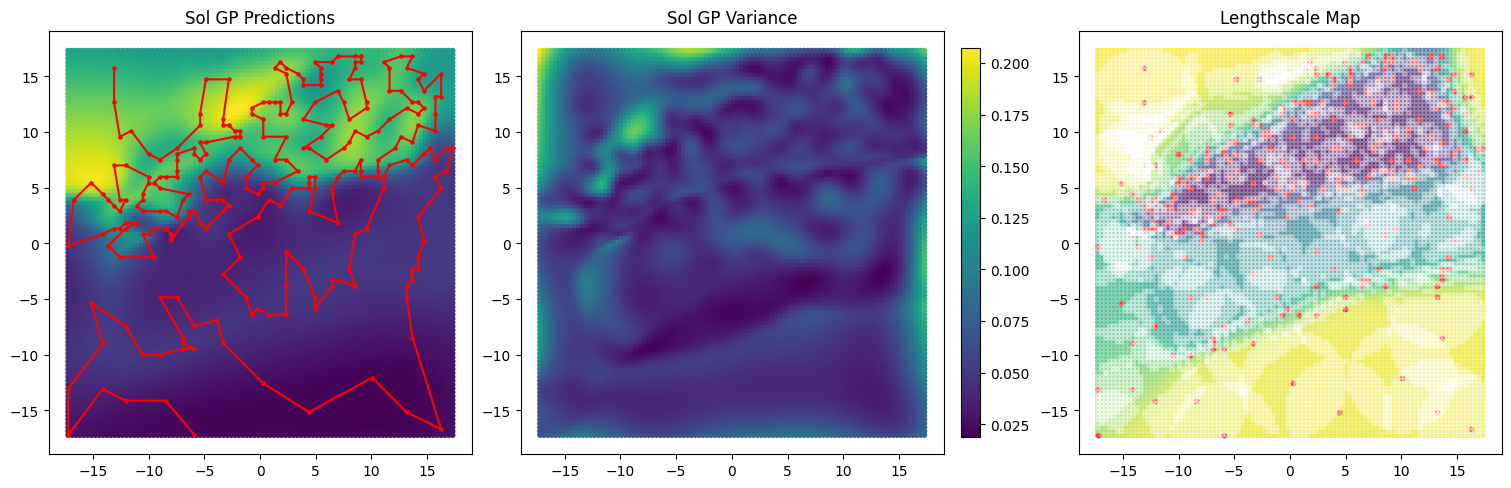

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(15, 10), constrained_layout=True)

# First subplot — training data
sc1 = axes[0].scatter(X_test[:, 0], X_test[:, 1], c=mean.numpy(), s=10)
axes[0].scatter(X_sol[:, 0], X_sol[:, 1], c='r', s=5)
axes[0].plot(sol_path[0][:, 0], sol_path[0][:, 1], c='r')
axes[0].set_title("Sol GP Predictions")
axes[0].set_aspect('equal')

# Second subplot — variance
sc2 = axes[1].scatter(X_test[:, 0], X_test[:, 1], c=var.numpy(), s=10)
#axes[1].scatter(X_candidates[:, 0], X_candidates[:, 1], c='r', s=1)
axes[1].set_title("Sol GP Variance")
axes[1].set_aspect('equal')

# Fix colorbar size
cbar = fig.colorbar(sc2, ax=axes[1], fraction=0.046, pad=0.04)

# Third subplot — lengthscale
cmap = np.sum(maps, axis=0).astype(float)
cmap /= np.max(cmap)
colors = [(1.0, 1.0, 1.0, alpha) for alpha in cmap]
axes[2].scatter(X_test[:, 0], X_test[:, 1], c=colors, s=10, zorder=10)
axes[2].scatter(X_test[:, 0], X_test[:, 1], c=env_ls, s=10)
axes[2].scatter(X_sol[:, 0], X_sol[:, 1], c='r', s=10)
axes[2].set_title("Lengthscale Map")
axes[2].set_aspect('equal')

'''
for pt, d in zip(X_sol, sol_lengthscales):
    circle = patches.Circle(pt, 
                            d/2, 
                            edgecolor='k', 
                            facecolor='w', 
                            alpha=0.1)
    axes[2].add_patch(circle)
'''

axes[2].set_xlim(axes[0].get_xlim())
axes[2].set_ylim(axes[0].get_ylim())

plt.show()

In [8]:
import numpy as np
from numba import njit


@njit
def _path_length_numba(points):
    """
    Total Euclidean length of a polyline. Numba version.
    """
    n = points.shape[0]
    if n < 2:
        return 0.0

    d = points.shape[1]
    total = 0.0
    for i in range(n - 1):
        s = 0.0
        for j in range(d):
            diff = points[i + 1, j] - points[i, j]
            s += diff * diff
        total += s ** 0.5
    return total


@njit
def _approx_dist_numba(p_nodes, x):
    """
    Approximate tour length after inserting point x into an existing route.
    Numba version of approx_dist.
    """
    n = p_nodes.shape[0]
    d = p_nodes.shape[1]

    if n == 0:
        return 0.0

    if n == 1:
        seq = np.empty((2, d), dtype=p_nodes.dtype)
        for j in range(d):
            seq[0, j] = p_nodes[0, j]
            seq[1, j] = x[j]
        return _path_length_numba(seq)

    # Distances from x to each existing node
    best_idx = 0
    best_dist = 1e30
    for i in range(n):
        s = 0.0
        for j in range(d):
            diff = p_nodes[i, j] - x[j]
            s += diff * diff
        dist = s ** 0.5
        if dist < best_dist:
            best_dist = dist
            best_idx = i

    idx = best_idx

    # Build two candidate sequences, as in the Python version
    if idx == n - 1:  # nearest is last
        # seq1: insert after last
        seq1 = np.empty((n + 1, d), dtype=p_nodes.dtype)
        for i in range(n):
            for j in range(d):
                seq1[i, j] = p_nodes[i, j]
        for j in range(d):
            seq1[n, j] = x[j]

        # seq2: insert before last
        seq2 = np.empty((n + 1, d), dtype=p_nodes.dtype)
        for i in range(n - 1):
            for j in range(d):
                seq2[i, j] = p_nodes[i, j]
        for j in range(d):
            seq2[n - 1, j] = x[j]
        for j in range(d):
            seq2[n, j] = p_nodes[n - 1, j]

    elif idx == 0:  # nearest is first
        # seq1: insert after first
        seq1 = np.empty((n + 1, d), dtype=p_nodes.dtype)
        for j in range(d):
            seq1[0, j] = p_nodes[0, j]
            seq1[1, j] = x[j]
        for i in range(1, n):
            for j in range(d):
                seq1[i + 1, j] = p_nodes[i, j]

        # seq2: insert before first
        seq2 = np.empty((n + 1, d), dtype=p_nodes.dtype)
        for j in range(d):
            seq2[0, j] = x[j]
        for i in range(n):
            for j in range(d):
                seq2[i + 1, j] = p_nodes[i, j]

    else:  # nearest is in the middle
        # seq1: insert after idx
        seq1 = np.empty((n + 1, d), dtype=p_nodes.dtype)
        # up to idx
        for i in range(idx + 1):
            for j in range(d):
                seq1[i, j] = p_nodes[i, j]
        # x
        for j in range(d):
            seq1[idx + 1, j] = x[j]
        # remaining
        for i in range(idx + 1, n):
            for j in range(d):
                seq1[i + 1, j] = p_nodes[i, j]

        # seq2: insert before idx
        seq2 = np.empty((n + 1, d), dtype=p_nodes.dtype)
        # up to idx-1
        for i in range(idx):
            for j in range(d):
                seq2[i, j] = p_nodes[i, j]
        # x
        for j in range(d):
            seq2[idx, j] = x[j]
        # from idx
        for i in range(idx, n):
            for j in range(d):
                seq2[i + 1, j] = p_nodes[i, j]

    dist1 = _path_length_numba(seq1)
    dist2 = _path_length_numba(seq2)

    if dist1 < dist2:
        return dist1
    else:
        return dist2


@njit
def _compute_deltas_all_numba(remaining_idxs, selected_idxs, X,
                              coverage_arr, current_cover, distance):
    """
    Numba-accelerated computation of distance_deltas and area_deltas
    for all remaining candidates.

    Parameters
    ----------
    remaining_idxs : 1D ndarray[int]
    selected_idxs : 1D ndarray[int]
    X : 2D ndarray[float], shape (m, d)
    coverage_arr : 2D ndarray[bool], shape (m, v)
    current_cover : 1D ndarray[bool], shape (v,)
    distance : float

    Returns
    -------
    distance_deltas : 1D ndarray[float]
    area_deltas : 1D ndarray[int]
    """
    m_rem = remaining_idxs.shape[0]
    v = current_cover.shape[0]
    d = X.shape[1]

    distance_deltas = np.empty(m_rem, dtype=np.float64)
    area_deltas = np.empty(m_rem, dtype=np.int64)

    # Build current route locations from selected_idxs
    n_sel = selected_idxs.shape[0]
    locs_current = np.empty((n_sel, d), dtype=X.dtype)
    for i in range(n_sel):
        idx_sel = selected_idxs[i]
        for j in range(d):
            locs_current[i, j] = X[idx_sel, j]

    for k in range(m_rem):
        idx = remaining_idxs[k]

        # Distance delta
        x = X[idx]
        new_distance = _approx_dist_numba(locs_current, x)
        distance_deltas[k] = new_distance - distance

        # Area delta = number of newly covered env points
        cov_i = coverage_arr[idx]
        gain = 0
        for j in range(v):
            if cov_i[j] and (not current_cover[j]):
                gain += 1
        area_deltas[k] = gain

    return distance_deltas, area_deltas


def gcb_binary(X, coverage_maps, distance_budget,
               target_fraction=0.99, n_jobs=-1):
    """
    Greedy coverage + budget (GCB) using binary coverage maps,
    with numba-accelerated inner computations.

    Parameters
    ----------
    X : ndarray (m, d)
        Candidate locations (e.g., X_sol from greedy_coverage).
    coverage_maps : Sequence[np.ndarray(bool)]
        coverage_maps[i] is a boolean array of shape (v,),
        indicating which env points candidate i covers.
    distance_budget : float
        Maximum allowed tour length.
    target_fraction : float, optional
        Target fraction of env points to cover (0–1).
    n_jobs : int, optional
        Unused in numba version (kept for API compatibility).

    Returns
    -------
    selected_idxs : list[int]
        Ordered list of candidate indices in X that are selected.
    """
    m = len(coverage_maps)
    if m == 0:
        return []

    X = np.asarray(X, dtype=np.float64)
    # Stack coverage maps into a single 2D bool array
    coverage_arr = np.vstack([np.asarray(cm, dtype=np.bool_) for cm in coverage_maps])

    v = coverage_arr.shape[1]
    target_area = int(v * float(target_fraction))

    # ---- 1) initial location: max coverage alone ----
    single_areas = coverage_arr.sum(axis=1)
    first_idx = int(np.argmax(single_areas))

    selected_idxs = [first_idx]
    distance = 0.0
    current_cover = coverage_arr[first_idx].copy()
    current_area = int(current_cover.sum())

    # Remaining candidates as a numpy array of indices
    remaining = np.array([i for i in range(m) if i != first_idx], dtype=np.int64)

    # ---- 2) iteratively add locations greedily ----
    while remaining.size > 0 and current_area < target_area:
        # Evaluate all remaining candidates via numba
        remaining_arr = remaining.astype(np.int64)
        selected_arr = np.array(selected_idxs, dtype=np.int64)

        distance_deltas, area_deltas = _compute_deltas_all_numba(
            remaining_arr, selected_arr, X, coverage_arr,
            current_cover, distance
        )

        # Compute area gain per unit extra distance.
        # If distance_delta <= 0, treat as almost-free in denominator.
        safe_dist = np.where(distance_deltas <= 0.0, 1e-9, distance_deltas)
        ratios = area_deltas / safe_dist

        # We'll iterate over candidates in order of decreasing ratio.
        while remaining.size > 0:
            pos = int(np.argmax(ratios))
            best_idx = int(remaining[pos])
            best_ratio = ratios[pos]

            # Remove from pool (whether we accept it or not)
            remaining = np.delete(remaining, pos)
            ratios = np.delete(ratios, pos)
            distance_deltas = np.delete(distance_deltas, pos)
            area_deltas = np.delete(area_deltas, pos)

            if best_ratio <= 0:
                # No beneficial candidates left
                remaining = np.array([], dtype=np.int64)
                break

            # Recompute route including this candidate, using run_tsp if available.
            idx_list = selected_idxs + [best_idx]
            locs = X[idx_list]

            # Real TSP solver:
            _, dist_list, indices_list = run_tsp(
                locs,
                initial_route=[list(range(1, len(locs) + 1))],
                return_indices=True,
                solution_limit=15
            )
            new_distance = dist_list[0]
            order = indices_list[0]
            new_selected_idxs = [idx_list[i] for i in order]

            if new_distance <= distance_budget:
                # Accept candidate and update coverage + distance
                selected_idxs = new_selected_idxs
                distance = new_distance

                # Recompute coverage and area
                current_cover = np.zeros_like(current_cover, dtype=np.bool_)
                for si in selected_idxs:
                    current_cover |= coverage_arr[si]
                current_area = int(current_cover.sum())

                break  # go back to outer while loop

    return selected_idxs

distance_budget = 1000.0
selected_order = gcb_binary(
    X=X_sol,
    coverage_maps=maps,
    distance_budget=distance_budget,
    target_fraction=1.0,
    n_jobs=-1,  # now ignored internally
)

X_route = X_sol[selected_order]
print("Number of selected sensors:", len(selected_order))

Number of selected sensors: 259


In [9]:
y_sol, _ = model.predict_f(X_route)
_, _, _, model_sol = get_model_params(
    X_train=X_route, y_train=y_sol, 
    kernel=kernel,
    max_steps=0,
    return_model=True,
    verbose=False)
mean, var = model_sol.predict_f(X_test)

#sol_path, _ = run_tsp(X_sol, time_limit=20)
sol_lengthscales = predict_lengthscales(X_route, lengthscales, kernel)

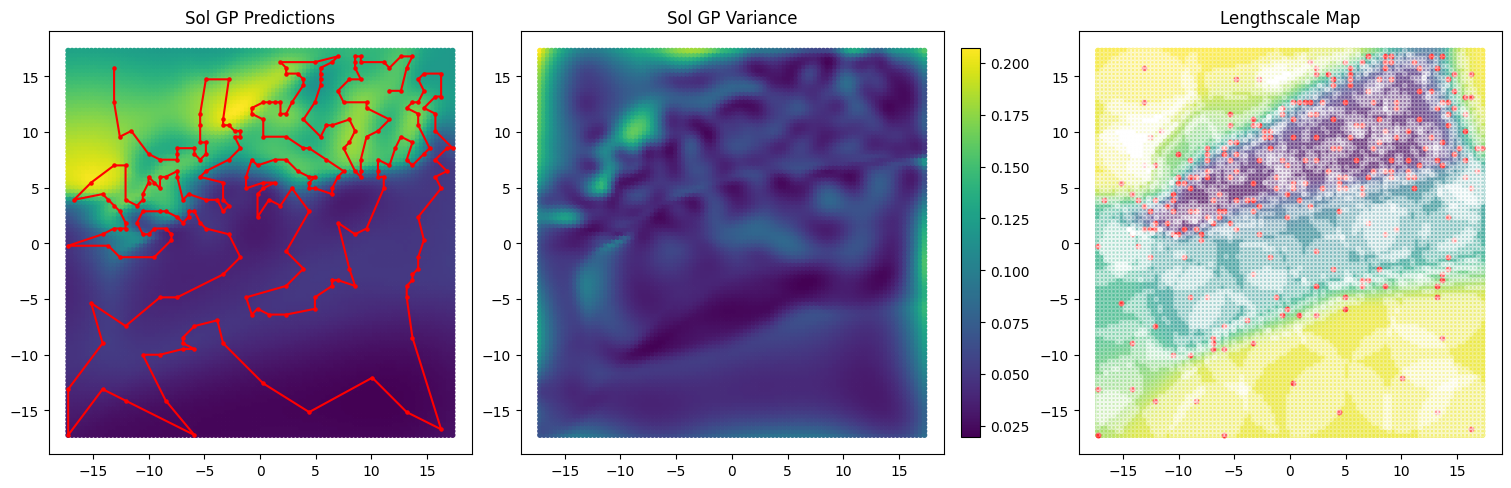

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(15, 10), constrained_layout=True)

# First subplot — training data
sc1 = axes[0].scatter(X_test[:, 0], X_test[:, 1], c=mean.numpy(), s=10)
axes[0].scatter(X_route[:, 0], X_route[:, 1], c='r', s=5)
axes[0].plot(X_route[:, 0], X_route[:, 1], c='r')
axes[0].set_title("Sol GP Predictions")
axes[0].set_aspect('equal')

# Second subplot — variance
sc2 = axes[1].scatter(X_test[:, 0], X_test[:, 1], c=var.numpy(), s=10)
#axes[1].scatter(X_candidates[:, 0], X_candidates[:, 1], c='r', s=1)
axes[1].set_title("Sol GP Variance")
axes[1].set_aspect('equal')

# Fix colorbar size
cbar = fig.colorbar(sc2, ax=axes[1], fraction=0.046, pad=0.04)

# Third subplot — lengthscale
cmap = np.sum(maps, axis=0).astype(float)
cmap /= np.max(cmap)
colors = [(1.0, 1.0, 1.0, alpha) for alpha in cmap]
axes[2].scatter(X_test[:, 0], X_test[:, 1], c=colors, s=10, zorder=10)
axes[2].scatter(X_test[:, 0], X_test[:, 1], c=env_ls, s=10)
axes[2].scatter(X_route[:, 0], X_route[:, 1], c='r', s=10)
axes[2].set_title("Lengthscale Map")
axes[2].set_aspect('equal')

'''
for pt, d in zip(X_sol, sol_lengthscales):
    circle = patches.Circle(pt, 
                            d/2, 
                            edgecolor='k', 
                            facecolor='w', 
                            alpha=0.1)
    axes[2].add_patch(circle)
'''

axes[2].set_xlim(axes[0].get_xlim())
axes[2].set_ylim(axes[0].get_ylim())

plt.show()